## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_wavelet_full_agriVision.ipynb


In [ ]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = True
CWD

AssertionError: 

In [ ]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [ ]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [ ]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:5]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 34762 CDFs


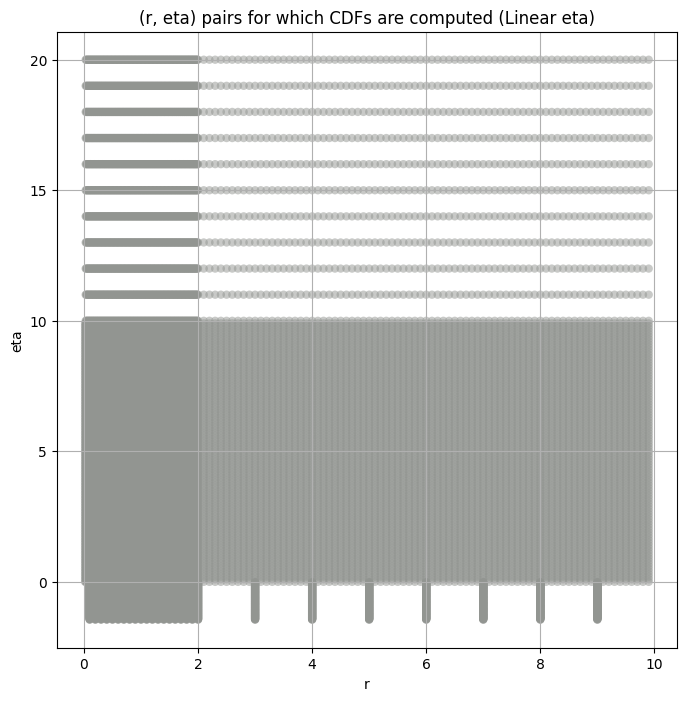

(r,eta),cdf     r  eta  \
0  ((0.02, 0), <scipy.interpolate._fitpack2.Inter...  0.02  0.0   
1  ((0.02, 0.1), <scipy.interpolate._fitpack2.Int...  0.02  0.1   
2  ((0.02, 0.2), <scipy.interpolate._fitpack2.Int...  0.02  0.2   
3  ((0.02, 0.3), <scipy.interpolate._fitpack2.Int...  0.02  0.3   
4  ((0.02, 0.4), <scipy.interpolate._fitpack2.Int...  0.02  0.4   

                                                 cdf       variance  kurtosis  
0  <scipy.interpolate._fitpack2.InterpolatedUniva...   4.553186e+99       NaN  
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.560477e+100       NaN  
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  6.013272e+101       NaN  
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.824903e+102       NaN  
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.104347e+103       NaN

In [ ]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [ ]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [ ]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  
layer                             
2       760.94360         9000.0  
3       891.27313        36000.0  
4      1768.95340       144000.0  
5      2074.88330       576000.0  
6      3444.52950      2304000.0  
7      5672.12000      9216000.0  
8      4638.63770     36864000.0  
9      6105.37160    147456000.0  
10     7496.85840    589824000.0

## Initial Grid Search and Hypothesis Test Plots

In [ ]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [ ]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      188570.730000  188570.734375    53255.480469    45081.785156   
3       42568.312000   42568.312500    17821.275391    14721.261719   
4       10773.336000   10773.335938     5597.328125     4464.237793   
5        1800.434900    1800.434937      967.196716      795.382263   
6         390.887500     390.887512      192.203186      158.687836   
7          98.479220      98.479218       42.509384       35.698841   
8          33.173733      33.173733       16.510288       13.967173   
9          11.252635      11.252635        4.574734        3.848108   
10          1.875914       1.875914        0.641675        0.543280   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        40213.917969     36420.285156     30676.792969     26366.972656   
3        13259.316406     12236.730469     10732.189453      9663.358398   
4         3925.427979      3574.999512      3107.311768      2816.859863   
5          702.730896       642.706543       566.309204       515.472717   
6          141.026688       129.362122       114.128799       104.113617   
7           32.237232        29.994589        27.104929        25.205553   
8           12.692533        11.896943        10.898866        10.253603   
9            3.496440         3.280626         3.007298         2.824955   
10           0.494285         0.463169         0.422697         0.395412   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         23064.148438     20511.724609     18413.591797     13823.259766  
3          8833.767578      8160.319824      7600.590332      6365.457520  
4          2605.477295      2443.711670      2310.490234      2000.593140  
5           477.084412       446.199188       420.567810       363.674988  
6            96.796181        91.054344        86.336449        75.977577  
7            23.804392        22.697041        21.784376        19.744150  
8             9.773006         9.387711         9.064301         8.316109  
9             2.686348         2.573658         2.478288         2.256173  
10            0.374613         0.357785         0.343469         0.310336

####
Layer  2


100%|██████████| 34762/34762 [00:12<00:00, 2716.81it/s]


Finding Minimum after computing 34762 CDFs
2 0 0.024065082317001163 188570.73


100%|██████████| 34762/34762 [00:11<00:00, 2911.22it/s]


Finding Minimum after computing 34762 CDFs
2 25 0.013681078230516064 53255.48


100%|██████████| 34762/34762 [00:11<00:00, 2933.50it/s]


Finding Minimum after computing 34762 CDFs
2 50 0.014755807792932951 45081.785


100%|██████████| 34762/34762 [00:12<00:00, 2857.14it/s]


Finding Minimum after computing 34762 CDFs
2 75 0.01611996530081919 40213.918
Number of samples: 9000, Without approximation : 9000.0


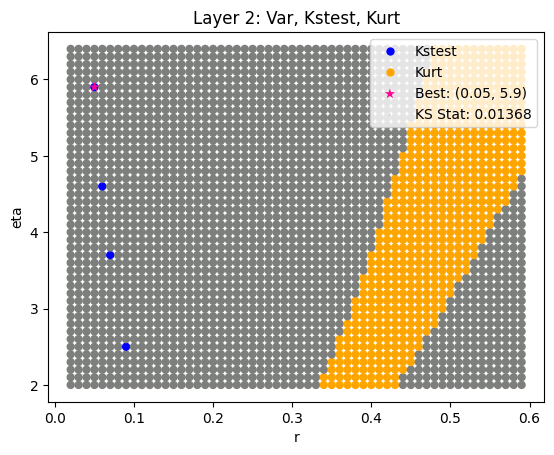

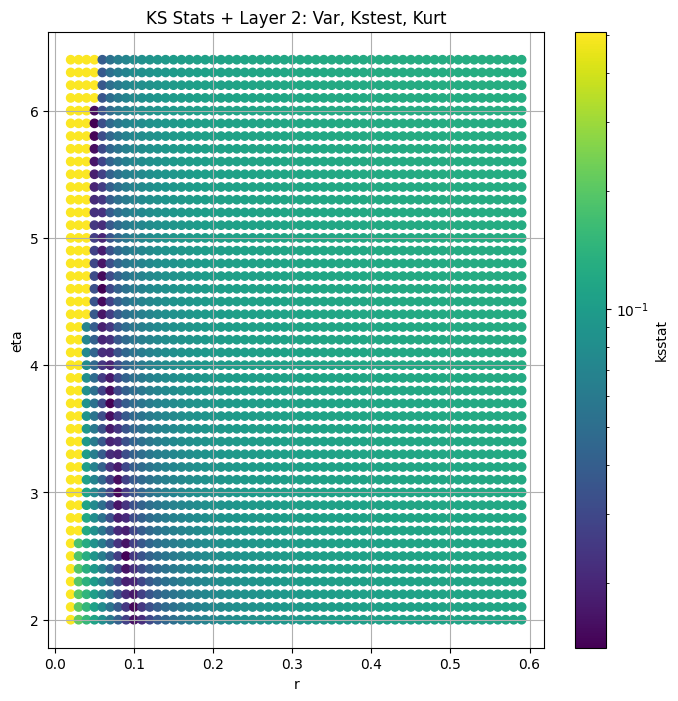

####
Layer  3


100%|██████████| 34762/34762 [00:45<00:00, 767.81it/s]


Finding Minimum after computing 34762 CDFs
3 0 0.02591192062126721 42568.312


100%|██████████| 34762/34762 [00:45<00:00, 760.89it/s]


Finding Minimum after computing 34762 CDFs
3 25 0.01652021173510307 17821.275


100%|██████████| 34762/34762 [00:45<00:00, 769.20it/s]


Finding Minimum after computing 34762 CDFs
3 50 0.014578485853438461 14721.262


100%|██████████| 34762/34762 [00:44<00:00, 780.04it/s]


Finding Minimum after computing 34762 CDFs
3 75 0.01421031822999319 13259.316


100%|██████████| 34762/34762 [00:44<00:00, 778.14it/s]


Finding Minimum after computing 34762 CDFs
3 100 0.013647110935017137 12236.73


100%|██████████| 34762/34762 [00:44<00:00, 779.95it/s]


Finding Minimum after computing 34762 CDFs
3 150 0.013072862728994716 10732.189


100%|██████████| 34762/34762 [00:45<00:00, 758.06it/s]


Finding Minimum after computing 34762 CDFs
3 200 0.012922924743000053 9663.358


100%|██████████| 34762/34762 [00:44<00:00, 775.23it/s]


Finding Minimum after computing 34762 CDFs
3 250 0.013713461651815584 8833.768


100%|██████████| 34762/34762 [00:45<00:00, 758.55it/s]


Finding Minimum after computing 34762 CDFs
3 300 0.014458325320286625 8160.32
Number of samples: 36000, Without approximation : 36000.0


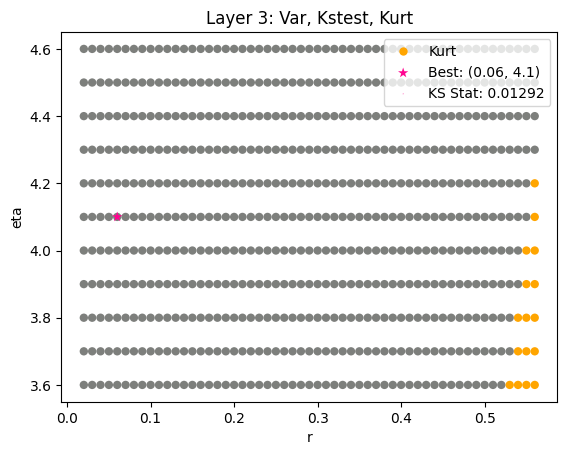

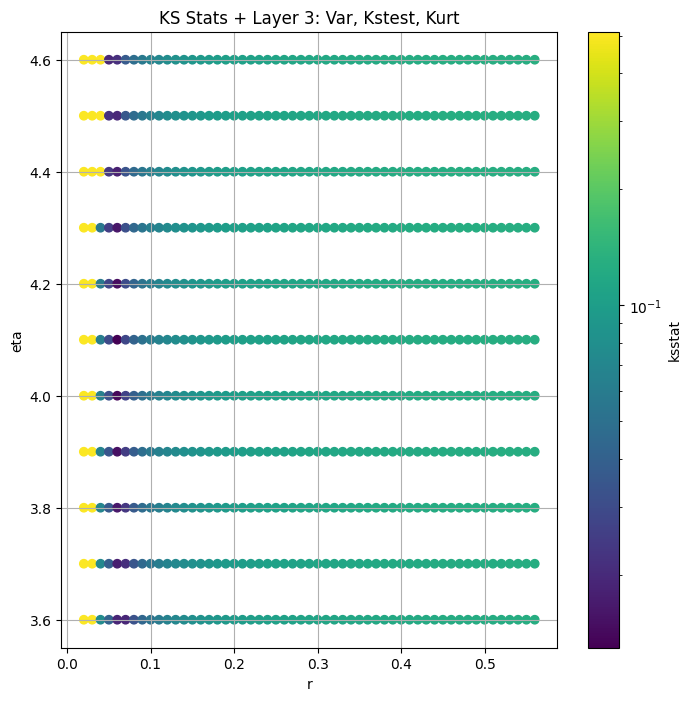

####
Layer  4


100%|██████████| 34762/34762 [02:08<00:00, 270.72it/s]


Finding Minimum after computing 34762 CDFs
4 0 0.02866491212943023 10773.336


100%|██████████| 34762/34762 [02:08<00:00, 269.77it/s]


Finding Minimum after computing 34762 CDFs
4 25 0.018420057163591852 5597.328


100%|██████████| 34762/34762 [02:02<00:00, 284.36it/s]


Finding Minimum after computing 34762 CDFs
4 50 0.015643832730302565 4464.238


100%|██████████| 34762/34762 [02:01<00:00, 286.67it/s]


Finding Minimum after computing 34762 CDFs
4 75 0.01351960969277441 3925.428


100%|██████████| 34762/34762 [01:59<00:00, 289.85it/s]


Finding Minimum after computing 34762 CDFs
4 100 0.01288981316703941 3574.9995


100%|██████████| 34762/34762 [02:03<00:00, 281.25it/s]


Finding Minimum after computing 34762 CDFs
4 150 0.011102429701610128 3107.3118


100%|██████████| 34762/34762 [01:55<00:00, 301.58it/s]


Finding Minimum after computing 34762 CDFs
4 200 0.01010819040291655 2816.8599


100%|██████████| 34762/34762 [01:54<00:00, 304.10it/s]


Finding Minimum after computing 34762 CDFs
4 250 0.008892951231167429 2605.4773


100%|██████████| 34762/34762 [01:54<00:00, 302.77it/s]


Finding Minimum after computing 34762 CDFs
4 300 0.00794988490137552 2443.7117


100%|██████████| 34762/34762 [01:58<00:00, 294.49it/s]


Finding Minimum after computing 34762 CDFs
4 350 0.007640419938646947 2310.4902


100%|██████████| 34762/34762 [01:54<00:00, 303.73it/s]


Finding Minimum after computing 34762 CDFs
4 500 0.008895289956498353 2000.5931
Number of samples: 100000, Without approximation : 144000.0


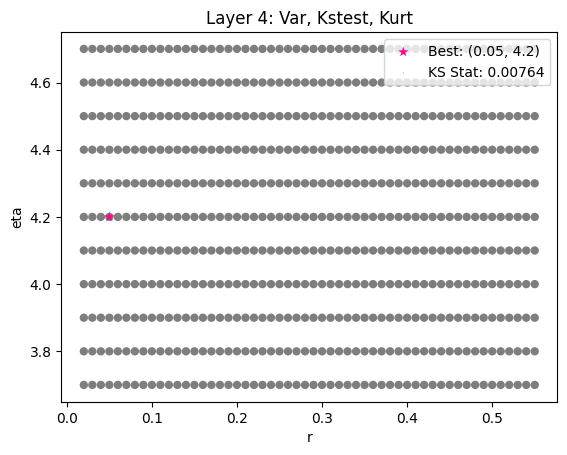

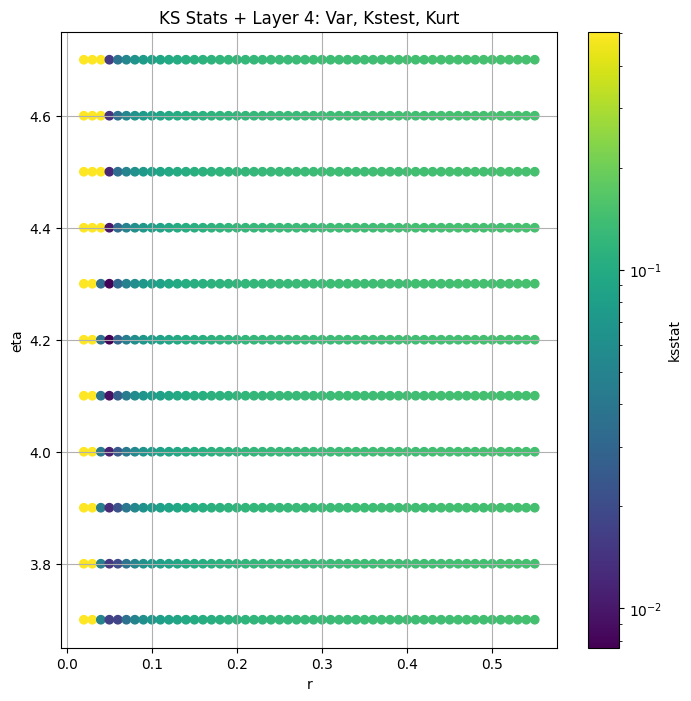

####
Layer  5


100%|██████████| 34762/34762 [01:54<00:00, 303.03it/s]


Finding Minimum after computing 34762 CDFs
5 0 0.025972857078906064 1800.4349


100%|██████████| 34762/34762 [01:54<00:00, 304.09it/s]


Finding Minimum after computing 34762 CDFs
5 25 0.017900217472383614 967.1967


100%|██████████| 34762/34762 [01:54<00:00, 302.57it/s]


Finding Minimum after computing 34762 CDFs
5 50 0.014691047530205267 795.38226


100%|██████████| 34762/34762 [01:54<00:00, 302.91it/s]


Finding Minimum after computing 34762 CDFs
5 75 0.0129973814192825 702.7309


100%|██████████| 34762/34762 [01:54<00:00, 303.62it/s]


Finding Minimum after computing 34762 CDFs
5 100 0.01097952806904394 642.70654


100%|██████████| 34762/34762 [01:54<00:00, 303.08it/s]


Finding Minimum after computing 34762 CDFs
5 150 0.009289516503620532 566.3092


100%|██████████| 34762/34762 [01:53<00:00, 305.58it/s]


Finding Minimum after computing 34762 CDFs
5 200 0.007486586538149015 515.4727


100%|██████████| 34762/34762 [01:53<00:00, 306.18it/s]


Finding Minimum after computing 34762 CDFs
5 250 0.006595878564900209 477.0844


100%|██████████| 34762/34762 [01:54<00:00, 304.55it/s]


Finding Minimum after computing 34762 CDFs
5 300 0.005897046840239284 446.1992


100%|██████████| 34762/34762 [01:58<00:00, 293.53it/s]


Finding Minimum after computing 34762 CDFs
5 350 0.006428706232798009 420.5678


100%|██████████| 34762/34762 [01:55<00:00, 299.71it/s]


Finding Minimum after computing 34762 CDFs
5 500 0.008194666848340026 363.675
Number of samples: 100000, Without approximation : 576000.0


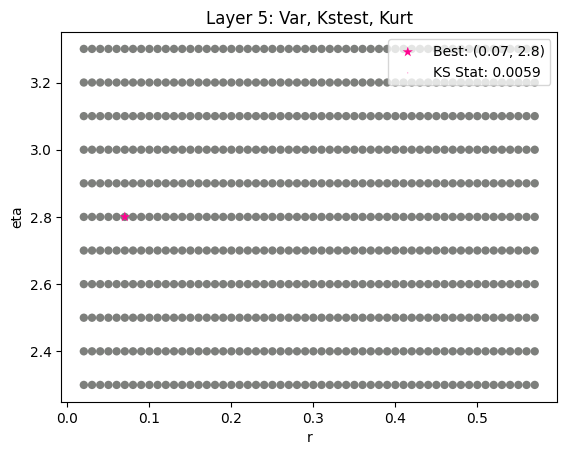

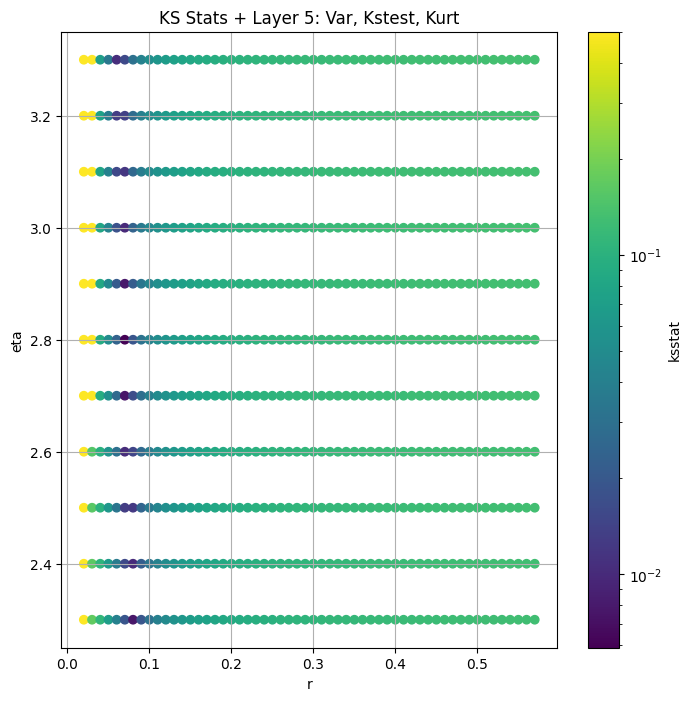

####
Layer  6


100%|██████████| 34762/34762 [01:56<00:00, 299.10it/s]


Finding Minimum after computing 34762 CDFs
6 0 0.027878517092720864 390.8875


100%|██████████| 34762/34762 [01:55<00:00, 301.45it/s]


Finding Minimum after computing 34762 CDFs
6 25 0.017044158528219236 192.20319


100%|██████████| 34762/34762 [01:56<00:00, 298.02it/s]


Finding Minimum after computing 34762 CDFs
6 50 0.013004379158550822 158.68784


100%|██████████| 34762/34762 [01:58<00:00, 292.50it/s]


Finding Minimum after computing 34762 CDFs
6 75 0.010609584364940167 141.02669


100%|██████████| 34762/34762 [01:55<00:00, 301.30it/s]


Finding Minimum after computing 34762 CDFs
6 100 0.009393652550666126 129.36212


100%|██████████| 34762/34762 [01:53<00:00, 304.96it/s]


Finding Minimum after computing 34762 CDFs
6 150 0.006385794526875321 114.1288


100%|██████████| 34762/34762 [01:53<00:00, 306.10it/s]


Finding Minimum after computing 34762 CDFs
6 200 0.004336922426086451 104.11362


100%|██████████| 34762/34762 [01:53<00:00, 304.94it/s]


Finding Minimum after computing 34762 CDFs
6 250 0.004093537406921088 96.79618


100%|██████████| 34762/34762 [01:53<00:00, 305.31it/s]


Finding Minimum after computing 34762 CDFs
6 300 0.004706824930265863 91.054344


100%|██████████| 34762/34762 [01:53<00:00, 306.52it/s]


Finding Minimum after computing 34762 CDFs
6 350 0.005317859572445016 86.33645
Number of samples: 100000, Without approximation : 2304000.0


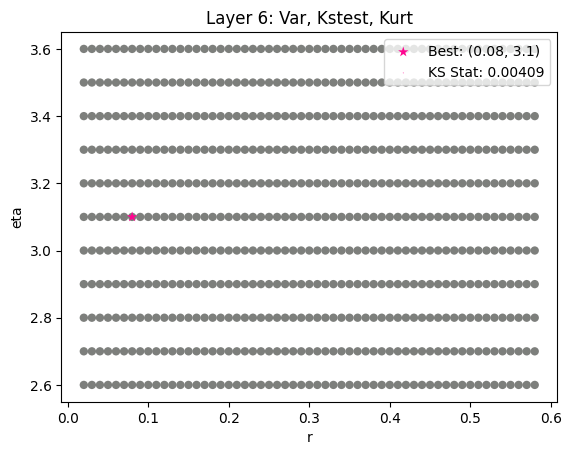

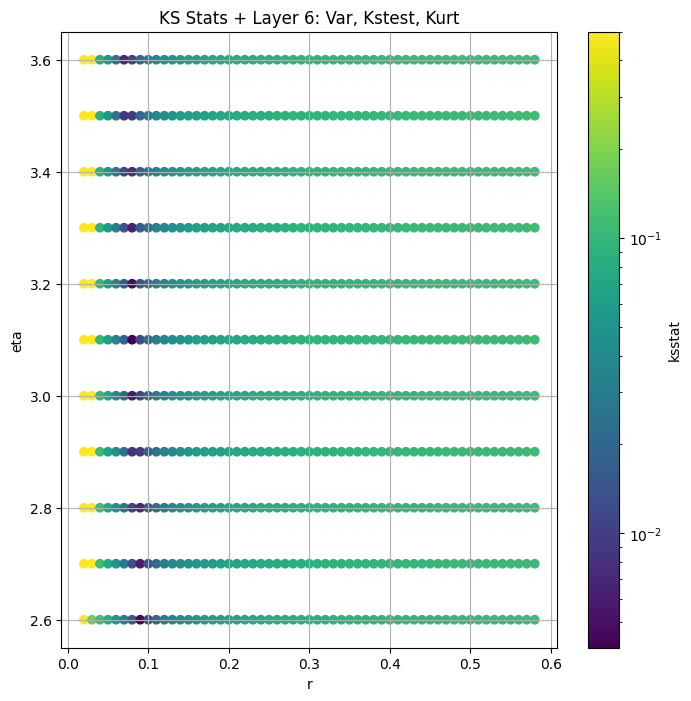

####
Layer  7


100%|██████████| 34762/34762 [01:56<00:00, 299.21it/s]


Finding Minimum after computing 34762 CDFs
7 0 0.028445411542838972 98.47922


100%|██████████| 34762/34762 [01:53<00:00, 305.16it/s]


Finding Minimum after computing 34762 CDFs
7 25 0.012966509118390812 42.509384


100%|██████████| 34762/34762 [01:53<00:00, 306.85it/s]


Finding Minimum after computing 34762 CDFs
7 50 0.008997478919192448 35.69884


100%|██████████| 34762/34762 [01:53<00:00, 306.61it/s]


Finding Minimum after computing 34762 CDFs
7 75 0.006750004049166702 32.237232


100%|██████████| 34762/34762 [01:54<00:00, 302.34it/s]


Finding Minimum after computing 34762 CDFs
7 100 0.0052897416112648865 29.994589


100%|██████████| 34762/34762 [01:54<00:00, 303.60it/s]


Finding Minimum after computing 34762 CDFs
7 150 0.003950983671614727 27.104929


100%|██████████| 34762/34762 [01:53<00:00, 305.77it/s]


Finding Minimum after computing 34762 CDFs
7 200 0.0038122530809918675 25.205553


100%|██████████| 34762/34762 [01:53<00:00, 306.81it/s]


Finding Minimum after computing 34762 CDFs
7 250 0.0038594083067428064 23.804392


100%|██████████| 34762/34762 [01:53<00:00, 306.93it/s]


Finding Minimum after computing 34762 CDFs
7 300 0.004331850572723783 22.69704
Number of samples: 100000, Without approximation : 9216000.0


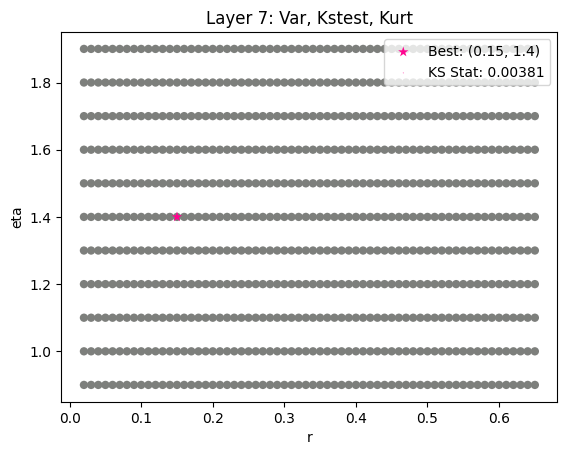

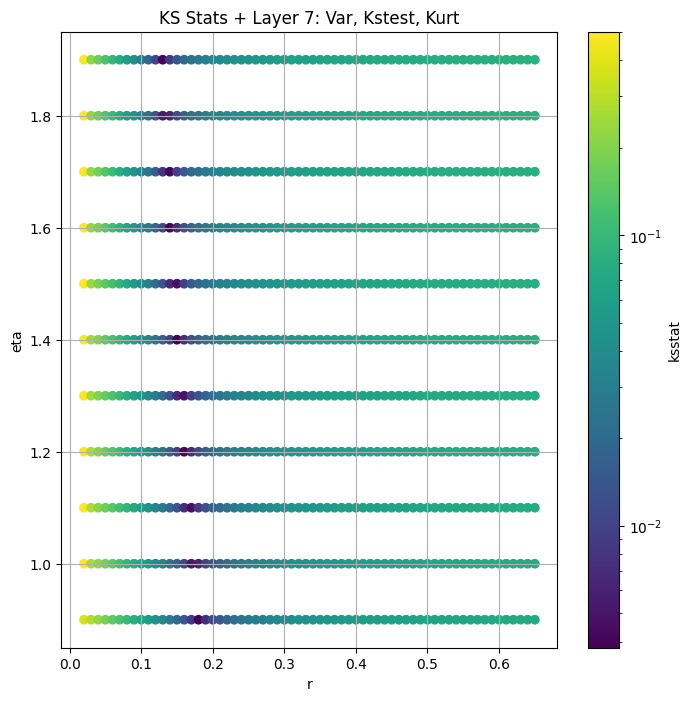

####
Layer  8


100%|██████████| 34762/34762 [01:54<00:00, 303.40it/s]


Finding Minimum after computing 34762 CDFs
8 0 0.021400611142691706 33.173733


100%|██████████| 34762/34762 [01:54<00:00, 304.16it/s]


Finding Minimum after computing 34762 CDFs
8 25 0.008631604680845895 16.510288


100%|██████████| 34762/34762 [01:53<00:00, 305.80it/s]


Finding Minimum after computing 34762 CDFs
8 50 0.004431160919522538 13.967173


100%|██████████| 34762/34762 [01:53<00:00, 306.60it/s]


Finding Minimum after computing 34762 CDFs
8 75 0.003349999999999853 12.692533


100%|██████████| 34762/34762 [01:53<00:00, 306.22it/s]


Finding Minimum after computing 34762 CDFs
8 100 0.0033499999999965224 11.896943


100%|██████████| 34762/34762 [01:53<00:00, 306.73it/s]


Finding Minimum after computing 34762 CDFs
8 150 0.0033499999999968555 10.898866


100%|██████████| 34762/34762 [01:53<00:00, 306.72it/s]


Finding Minimum after computing 34762 CDFs
8 200 0.0033499999999965224 10.253603
Number of samples: 100000, Without approximation : 36864000.0


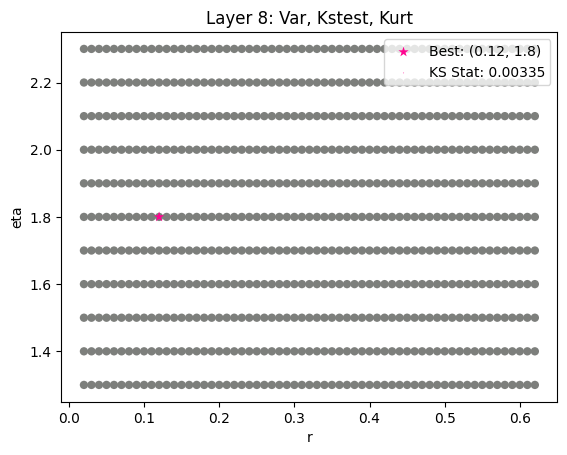

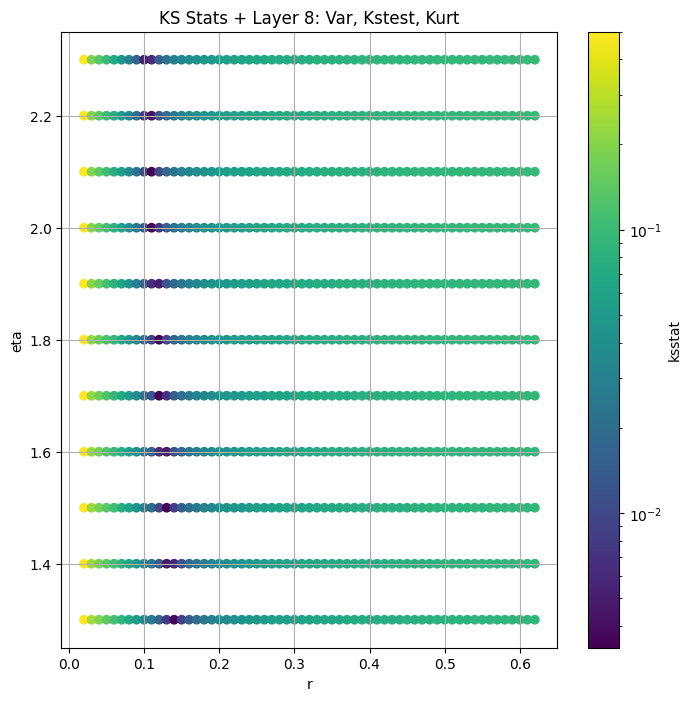

####
Layer  9


100%|██████████| 34762/34762 [01:53<00:00, 306.29it/s]


Finding Minimum after computing 34762 CDFs
9 0 0.024747447998198113 11.252635


100%|██████████| 34762/34762 [01:53<00:00, 306.06it/s]


Finding Minimum after computing 34762 CDFs
9 25 0.009136994247288865 4.5747337


100%|██████████| 34762/34762 [01:53<00:00, 305.89it/s]


Finding Minimum after computing 34762 CDFs
9 50 0.005950000000000011 3.8481076


100%|██████████| 34762/34762 [01:53<00:00, 306.19it/s]


Finding Minimum after computing 34762 CDFs
9 75 0.005949999999996014 3.4964397


100%|██████████| 34762/34762 [01:53<00:00, 305.94it/s]


Finding Minimum after computing 34762 CDFs
9 100 0.005949999999982691 3.2806263


100%|██████████| 34762/34762 [01:53<00:00, 306.03it/s]


Finding Minimum after computing 34762 CDFs
9 150 0.005949999999982469 3.0072985


100%|██████████| 34762/34762 [01:53<00:00, 305.79it/s]


Finding Minimum after computing 34762 CDFs
9 200 0.005949999999984024 2.8249547


100%|██████████| 34762/34762 [01:53<00:00, 304.99it/s]


Finding Minimum after computing 34762 CDFs
9 250 0.005949999999985134 2.686348
Number of samples: 100000, Without approximation : 147456000.0


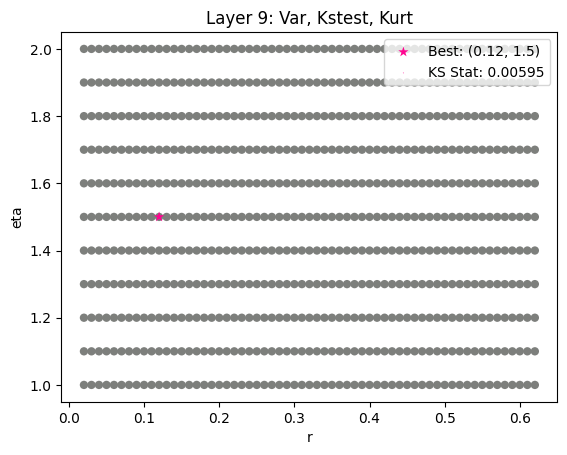

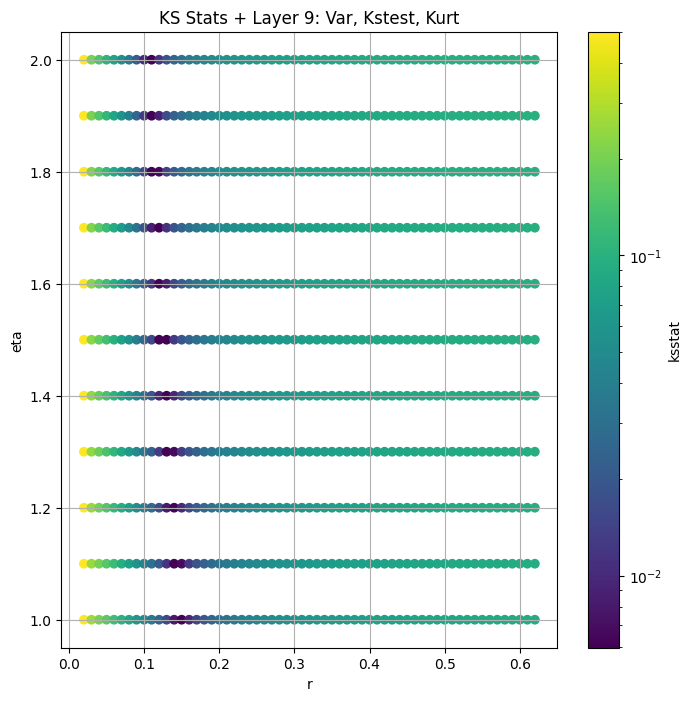

####
Layer  10


100%|██████████| 34762/34762 [01:57<00:00, 295.84it/s]


Finding Minimum after computing 34762 CDFs
10 0 0.02924344561515088 1.8759142


100%|██████████| 34762/34762 [01:57<00:00, 296.74it/s]


Finding Minimum after computing 34762 CDFs
10 25 0.026099999999986523 0.6416747


100%|██████████| 34762/34762 [01:56<00:00, 299.66it/s]


Finding Minimum after computing 34762 CDFs
10 50 0.02609999999998447 0.5432802


100%|██████████| 34762/34762 [01:56<00:00, 298.81it/s]


Finding Minimum after computing 34762 CDFs
10 75 0.026099999999983192 0.4942845


100%|██████████| 34762/34762 [01:55<00:00, 299.92it/s]


Finding Minimum after computing 34762 CDFs
10 100 0.026099999999981527 0.4631687


100%|██████████| 34762/34762 [01:56<00:00, 299.20it/s]


Finding Minimum after computing 34762 CDFs
10 150 0.026099999999979917 0.42269677


100%|██████████| 34762/34762 [01:54<00:00, 304.08it/s]


Finding Minimum after computing 34762 CDFs
10 200 0.02609999999998014 0.39541236


100%|██████████| 34762/34762 [01:55<00:00, 301.47it/s]


Finding Minimum after computing 34762 CDFs
10 250 0.026099999999978696 0.3746135


100%|██████████| 34762/34762 [01:55<00:00, 300.21it/s]


Finding Minimum after computing 34762 CDFs
10 300 0.026099999999977863 0.35778508


100%|██████████| 34762/34762 [01:54<00:00, 304.82it/s]


Finding Minimum after computing 34762 CDFs
10 350 0.02609999999997764 0.34346884


100%|██████████| 34762/34762 [01:54<00:00, 304.48it/s]


Finding Minimum after computing 34762 CDFs
10 500 0.02609999999997692 0.3103359
Number of samples: 100000, Without approximation : 589824000.0


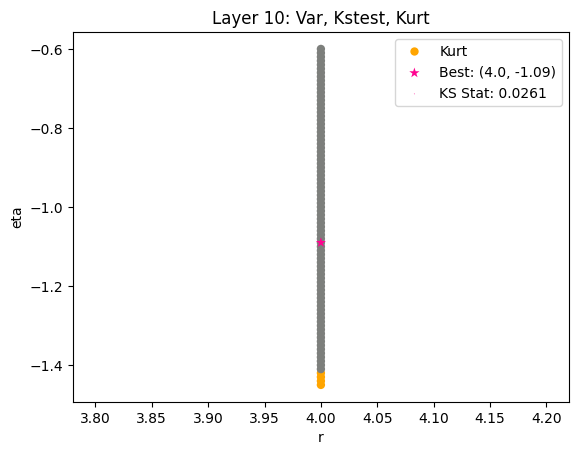

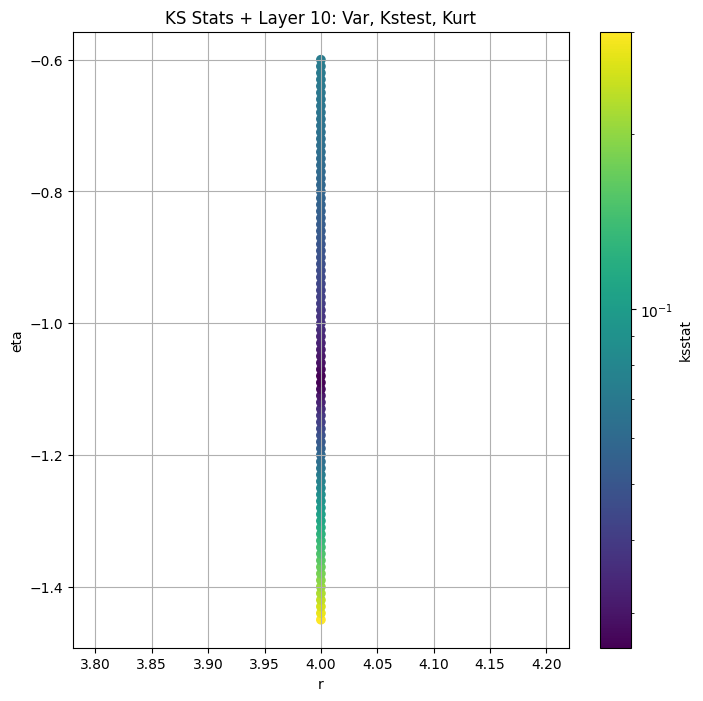

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       760.94360         9000.0             0.013681       0.05         5.90   
3       891.27313        36000.0             0.012923       0.06         4.10   
4      1768.95340       144000.0             0.007640       0.05         4.20   
5      2074.88330       576000.0             0.005897       0.07         2.80   
6      3444.52950      2304000.0             0.004094       0.08         3.10   
7      5672.12000      9216000.0             0.003812       0.15         1.40   
8      4638.63770     36864000.0             0.003350       0.12         1.80   
9      6105.37160    147456000.0             0.005950       0.12         1.50   
10     7496.85840    589824000.0             0.026100       4.00        -1.09   

       initial_scale  best_exclude_cutoff  best_augmented_var  \
layer                                                           
2       6.117604e-40                 25.0        53255.480000   
3       3.767124e-30                200.0         9663.358000   
4       3.466181e-39                350.0         2310.490200   
5       2.990083e-24                300.0          446.199200   
6       3.029738e-21                250.0           96.796180   
7       2.759916e-08                200.0           25.205553   
8       4.352079e-12                100.0           11.896943   
9       2.218216e-12                150.0            3.007299   
10      1.138467e+00                500.0            0.310336   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1
        no_improvement_counter = 0

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]

            if no_improvement_counter > 1:
                break

            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
            else:
                no_improvement_counter += 1
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

In [ ]:
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      188570.730000  188570.730000    53255.480000    45081.785000   
3       42568.312000   42568.312000    17821.275000    14721.262000   
4       10773.336000   10773.336000     5597.328000     4464.238000   
5        1800.434900    1800.434900      967.196700      795.382260   
6         390.887500     390.887500      192.203190      158.687840   
7          98.479220      98.479220       42.509384       35.698840   
8          33.173733      33.173733       16.510288       13.967173   
9          11.252635      11.252635        4.574734        3.848108   
10          1.875914       1.875914        0.641675        0.543280   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        40213.918000     36420.285000     30676.793000     26366.973000   
3        13259.316000     12236.730000     10732.189000      9663.358000   
4         3925.428000      3574.999500      3107.311800      2816.859900   
5          702.730900       642.706540       566.309200       515.472700   
6          141.026690       129.362120       114.128800       104.113620   
7           32.237232        29.994589        27.104929        25.205553   
8           12.692533        11.896943        10.898866        10.253603   
9            3.496440         3.280626         3.007299         2.824955   
10           0.494285         0.463169         0.422697         0.395412   

       var_exclude_250  var_exclude_300  ...  kstest_stat_25  kstest_stat_50  \
layer                                    ...                                   
2         23064.148000     20511.725000  ...        0.013681        0.014756   
3          8833.768000      8160.320000  ...        0.016520        0.014578   
4          2605.477300      2443.711700  ...        0.018420        0.015644   
5           477.084400       446.199200  ...        0.017900        0.014691   
6            96.796180        91.054344  ...        0.017044        0.013004   
7            23.804392        22.697040  ...        0.012967        0.008997   
8             9.773006         9.387711  ...        0.008632        0.004431   
9             2.686348         2.573658  ...        0.009137        0.005950   
10            0.374613         0.357785  ...        0.026100        0.026100   

       kstest_stat_75  kstest_stat_100  kstest_stat_150  kstest_stat_200  \
layer                                                                      
2            0.016120              NaN              NaN              NaN   
3            0.014210         0.013647         0.013073         0.012923   
4            0.013520         0.012890         0.011102         0.010108   
5            0.012997         0.010980         0.009290         0.007487   
6            0.010610         0.009394         0.006386         0.004337   
7            0.006750         0.005290         0.003951         0.003812   
8            0.003350         0.003350         0.003350         0.003350   
9            0.005950         0.005950         0.005950         0.005950   
10           0.026100         0.026100         0.026100         0.026100   

       kstest_stat_250  kstest_stat_300  kstest_stat_350  kstest_stat_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3             0.013713         0.014458              NaN              NaN  
4             0.008893         0.007950         0.007640         0.008895  
5             0.006596         0.005897         0.006429         0.008195  
6             0.004094         0.004707         0.005318              NaN  
7             0.003859         0.004332              NaN              NaN  
8                  NaN              NaN              NaN            

## Optimization

In [ ]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2
(0.042, 5.89), 50 of 420
(0.044, 5.99), 100 of 420
(0.047, 5.89), 150 of 420
(0.049, 5.99), 200 of 420
(0.052, 5.89), 250 of 420
(0.054, 5.99), 300 of 420
(0.057, 5.89), 350 of 420
(0.059, 5.99), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 1742.38it/s]


Finding Minimum after computing 420 CDFs
2 -50 0 0.10300313443516321 188570.73 minus50


100%|██████████| 420/420 [00:00<00:00, 1840.50it/s]


Finding Minimum after computing 420 CDFs
2 -40 0 0.10300313443516321 188570.73 minus40


100%|██████████| 420/420 [00:00<00:00, 1816.90it/s]


Finding Minimum after computing 420 CDFs
2 -30 0 0.10300313443516321 188570.73 minus30


100%|██████████| 420/420 [00:00<00:00, 1829.73it/s]


Finding Minimum after computing 420 CDFs
2 -20 5 0.04844498493361346 88252.984 minus20


100%|██████████| 420/420 [00:00<00:00, 1821.36it/s]


Finding Minimum after computing 420 CDFs
2 -10 15 0.019542474811923033 60329.15 minus10


100%|██████████| 420/420 [00:00<00:00, 1826.80it/s]


Finding Minimum after computing 420 CDFs
2 0 25 0.013406348767533216 53255.48 0


100%|██████████| 420/420 [00:00<00:00, 1574.96it/s]


Finding Minimum after computing 420 CDFs
2 10 35 0.014446751625826648 49089.87 plus10


100%|██████████| 420/420 [00:00<00:00, 1831.67it/s]


Finding Minimum after computing 420 CDFs
2 20 45 0.015836036936907383 46275.16 plus20


100%|██████████| 420/420 [00:00<00:00, 1817.37it/s]


Finding Minimum after computing 420 CDFs
2 30 55 0.017096331505381146 43991.477 plus30


100%|██████████| 420/420 [00:00<00:00, 1834.79it/s]


Finding Minimum after computing 420 CDFs
2 40 65 0.018720300476272156 41988.145 plus40


100%|██████████| 420/420 [00:00<00:00, 1809.47it/s]


Finding Minimum after computing 420 CDFs
2 50 75 0.020482672345441544 40213.918 plus50
Number of samples: 9000, Without approximation : 9000.0
Iter 1 layer 2 best parameters: (0.05, 5.88, 6.437223718837544e-40, 25.0, 0.013406348767533216)


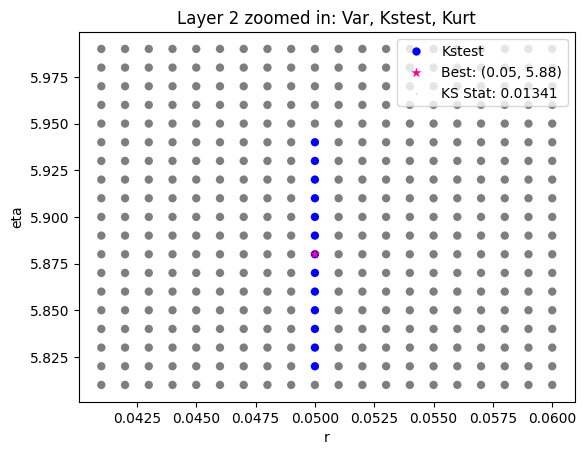

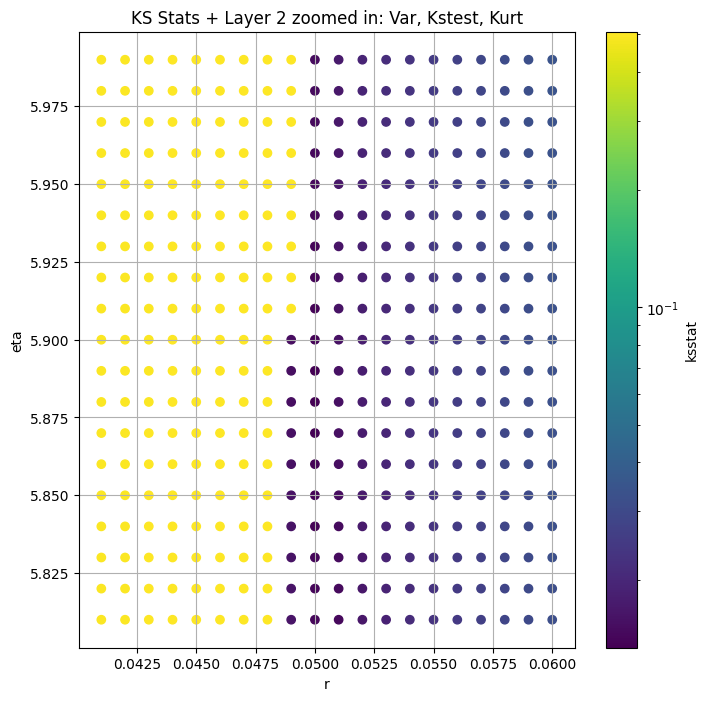

Layer 3
(0.052, 4.09), 50 of 400
(0.054, 4.19), 100 of 400
(0.057, 4.09), 150 of 400
(0.059, 4.19), 200 of 400
(0.062, 4.09), 250 of 400
(0.064, 4.19), 300 of 400
(0.067, 4.09), 350 of 400
(0.069, 4.19), 400 of 400


100%|██████████| 400/400 [00:00<00:00, 507.30it/s]


Finding Minimum after computing 400 CDFs
3 -50 150 0.013042128244724283 10732.189 minus50


100%|██████████| 400/400 [00:00<00:00, 517.76it/s]


Finding Minimum after computing 400 CDFs
3 -40 160 0.01296880706878012 10491.656 minus40


100%|██████████| 400/400 [00:00<00:00, 516.66it/s]


Finding Minimum after computing 400 CDFs
3 -30 170 0.012929171869449307 10265.392 minus30


100%|██████████| 400/400 [00:00<00:00, 505.54it/s]


Finding Minimum after computing 400 CDFs
3 -20 180 0.012899912832746607 10053.563 minus20


100%|██████████| 400/400 [00:00<00:00, 514.67it/s]


Finding Minimum after computing 400 CDFs
3 -10 170 0.012929171869449307 10265.392 minus10


100%|██████████| 400/400 [00:00<00:00, 517.13it/s]


Finding Minimum after computing 400 CDFs
3 0 180 0.012899912832746607 10053.563 0


100%|██████████| 400/400 [00:00<00:00, 515.28it/s]


Finding Minimum after computing 400 CDFs
3 10 190 0.012870387712165976 9853.148 plus10


100%|██████████| 400/400 [00:00<00:00, 502.16it/s]


Finding Minimum after computing 400 CDFs
3 20 210 0.01333531854513026 9482.136 plus20


100%|██████████| 400/400 [00:00<00:00, 506.49it/s]


Finding Minimum after computing 400 CDFs
3 30 220 0.013735202945558411 9307.587 plus30


100%|██████████| 400/400 [00:00<00:00, 512.55it/s]


Finding Minimum after computing 400 CDFs
3 40 230 0.014111583838038455 9142.759 plus40


100%|██████████| 400/400 [00:00<00:00, 495.73it/s]


Finding Minimum after computing 400 CDFs
3 50 240 0.014489739923300715 8985.437 plus50
Number of samples: 36000, Without approximation : 36000.0
Iter 1 layer 3 best parameters: (0.059, 4.13, 7.202922628328142e-31, 190.0, 0.012870387712165976)


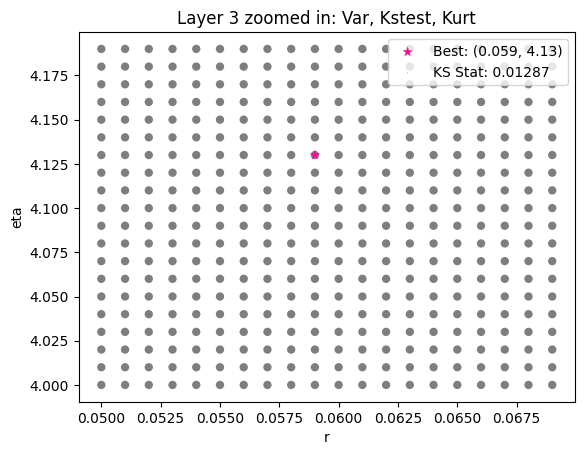

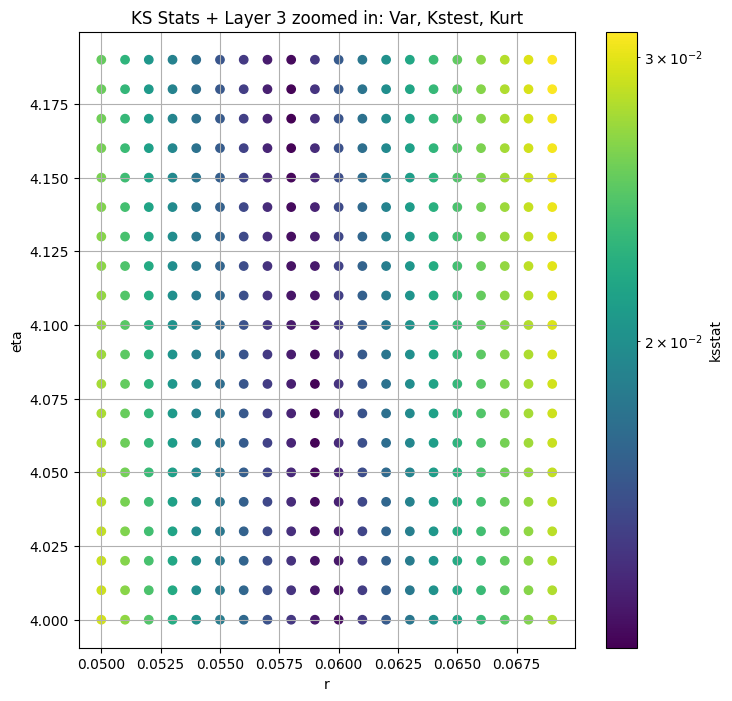

Layer 4
(0.042, 4.19), 50 of 420
(0.044, 4.29), 100 of 420
(0.047, 4.19), 150 of 420
(0.049, 4.29), 200 of 420
(0.052, 4.19), 250 of 420
(0.054, 4.29), 300 of 420
(0.057, 4.19), 350 of 420
(0.059, 4.29), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 305.19it/s]


Finding Minimum after computing 420 CDFs
4 -50 300 0.00749109809117901 2443.7117 minus50


100%|██████████| 420/420 [00:01<00:00, 309.85it/s]


Finding Minimum after computing 420 CDFs
4 -40 260 0.008077890264967996 2570.034 minus40


100%|██████████| 420/420 [00:01<00:00, 306.47it/s]


Finding Minimum after computing 420 CDFs
4 -30 270 0.007931285666011756 2536.3638 minus30


100%|██████████| 420/420 [00:02<00:00, 172.20it/s]


Finding Minimum after computing 420 CDFs
4 -20 280 0.007796414206190594 2504.2004 minus20


100%|██████████| 420/420 [00:02<00:00, 205.25it/s]


Finding Minimum after computing 420 CDFs
4 -10 290 0.007644513554369903 2473.4043 minus10


100%|██████████| 420/420 [02:52<00:00,  2.44it/s]


Finding Minimum after computing 420 CDFs
4 0 300 0.00749109809117901 2443.7117 0


100%|██████████| 420/420 [00:01<00:00, 280.59it/s]


Finding Minimum after computing 420 CDFs
4 10 310 0.007368175235516999 2415.2205 plus10


100%|██████████| 420/420 [00:01<00:00, 295.15it/s]


Finding Minimum after computing 420 CDFs
4 20 330 0.007157205556198587 2361.1492 plus20


100%|██████████| 420/420 [00:01<00:00, 297.32it/s]


Finding Minimum after computing 420 CDFs
4 30 360 0.007559028297121517 2286.2122 plus30


100%|██████████| 420/420 [00:01<00:00, 306.69it/s]


Finding Minimum after computing 420 CDFs
4 40 370 0.007693645949008121 2262.4285 plus40


100%|██████████| 420/420 [00:01<00:00, 302.04it/s]


Finding Minimum after computing 420 CDFs
4 50 380 0.007852370727432278 2239.3176 plus50
Number of samples: 100000, Without approximation : 144000.0
Iter 1 layer 4 best parameters: (0.05, 4.18, 3.780162377981533e-39, 330.0, 0.007157205556198587)


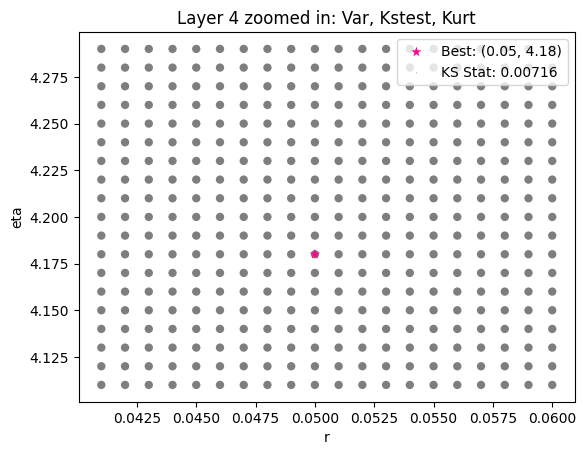

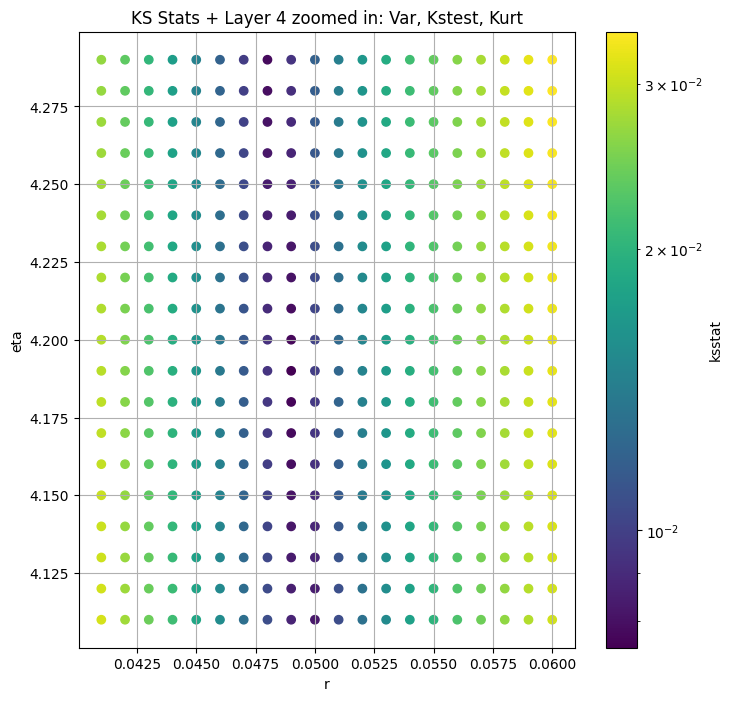

Layer 5
(0.062, 2.77), 50 of 420
(0.064, 2.85), 100 of 420
(0.067, 2.72), 150 of 420
(0.069, 2.8), 200 of 420
(0.071, 2.88), 250 of 420
(0.074, 2.75), 300 of 420
(0.076, 2.83), 350 of 420
(0.079, 2.7), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 302.03it/s]


Finding Minimum after computing 420 CDFs
5 -50 250 0.006532760761339462 477.0844 minus50


100%|██████████| 420/420 [00:01<00:00, 306.78it/s]


Finding Minimum after computing 420 CDFs
5 -40 260 0.006294531371925038 470.41837 minus40


100%|██████████| 420/420 [00:01<00:00, 307.36it/s]


Finding Minimum after computing 420 CDFs
5 -30 270 0.006081565985245452 464.02597 minus30


100%|██████████| 420/420 [00:01<00:00, 308.25it/s]


Finding Minimum after computing 420 CDFs
5 -20 280 0.005887595034780424 457.86453 minus20


100%|██████████| 420/420 [00:01<00:00, 306.05it/s]


Finding Minimum after computing 420 CDFs
5 -10 270 0.006081565985245452 464.02597 minus10


100%|██████████| 420/420 [00:01<00:00, 308.14it/s]


Finding Minimum after computing 420 CDFs
5 0 280 0.005887595034780424 457.86453 0


100%|██████████| 420/420 [00:01<00:00, 308.40it/s]


Finding Minimum after computing 420 CDFs
5 10 290 0.005734559061916222 451.9272 plus10


100%|██████████| 420/420 [00:01<00:00, 306.42it/s]


Finding Minimum after computing 420 CDFs
5 20 310 0.006049705131939365 440.7035 plus20


100%|██████████| 420/420 [00:01<00:00, 307.58it/s]


Finding Minimum after computing 420 CDFs
5 30 320 0.006203832521720853 435.38834 plus30


100%|██████████| 420/420 [00:01<00:00, 306.49it/s]


Finding Minimum after computing 420 CDFs
5 40 330 0.006357626977683828 430.2703 plus40


100%|██████████| 420/420 [00:01<00:00, 307.30it/s]


Finding Minimum after computing 420 CDFs
5 50 340 0.006513154889277506 425.3346 plus50
Number of samples: 100000, Without approximation : 576000.0
Iter 1 layer 5 best parameters: (0.069, 2.81, 9.940858364792069e-25, 290.0, 0.005734559061916222)


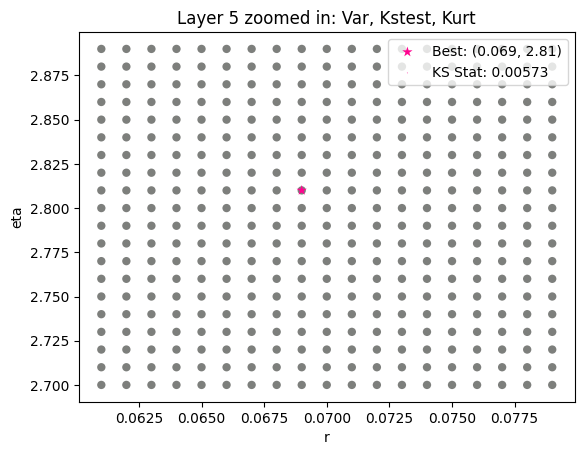

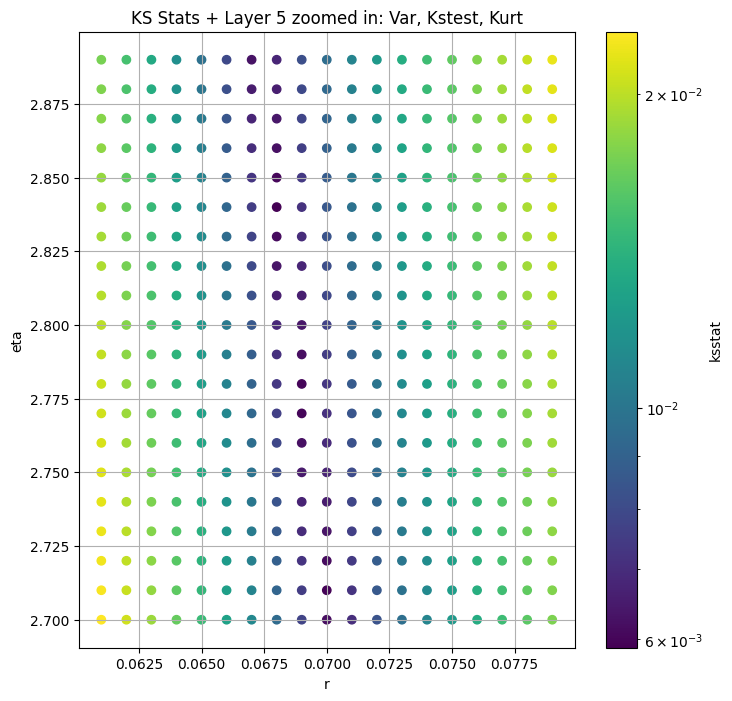

Layer 6
(0.072, 3.07), 50 of 420
(0.074, 3.15), 100 of 420
(0.077, 3.02), 150 of 420
(0.079, 3.1), 200 of 420
(0.081, 3.18), 250 of 420
(0.084, 3.05), 300 of 420
(0.086, 3.13), 350 of 420
(0.089, 3.0), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 269.58it/s]


Finding Minimum after computing 420 CDFs
6 -50 200 0.005032170484313134 104.11362 minus50


100%|██████████| 420/420 [00:02<00:00, 148.55it/s]


Finding Minimum after computing 420 CDFs
6 -40 210 0.004765250574991678 102.48199 minus40


100%|██████████| 420/420 [00:02<00:00, 175.27it/s]


Finding Minimum after computing 420 CDFs
6 -30 220 0.004463783833411214 100.9451 minus30


100%|██████████| 420/420 [00:01<00:00, 295.93it/s]


Finding Minimum after computing 420 CDFs
6 -20 230 0.004171923466138094 99.48919 minus20


100%|██████████| 420/420 [00:01<00:00, 291.81it/s]


Finding Minimum after computing 420 CDFs
6 -10 240 0.003956363003360219 98.109856 minus10


100%|██████████| 420/420 [00:01<00:00, 305.34it/s]


Finding Minimum after computing 420 CDFs
6 0 240 0.003956363003360219 98.109856 0


100%|██████████| 420/420 [00:01<00:00, 307.03it/s]


Finding Minimum after computing 420 CDFs
6 10 250 0.004085255015373601 96.79618 plus10


100%|██████████| 420/420 [00:01<00:00, 310.69it/s]


Finding Minimum after computing 420 CDFs
6 20 260 0.004214388472984498 95.542076 plus20


100%|██████████| 420/420 [00:01<00:00, 308.75it/s]


Finding Minimum after computing 420 CDFs
6 30 270 0.0043451148658121275 94.346954 plus30


100%|██████████| 420/420 [00:01<00:00, 308.08it/s]


Finding Minimum after computing 420 CDFs
6 40 280 0.0044824888502909 93.20369 plus40


100%|██████████| 420/420 [00:01<00:00, 311.55it/s]


Finding Minimum after computing 420 CDFs
6 50 290 0.004618945785974771 92.1076 plus50
Number of samples: 100000, Without approximation : 2304000.0
Iter 1 layer 6 best parameters: (0.078, 3.17, 4.913900350130537e-22, 240.0, 0.003956363003360219)


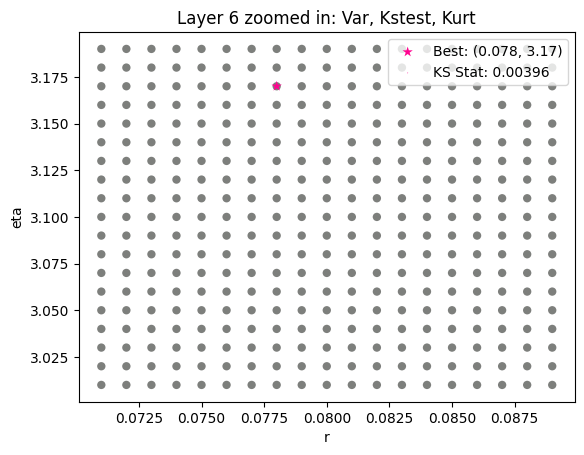

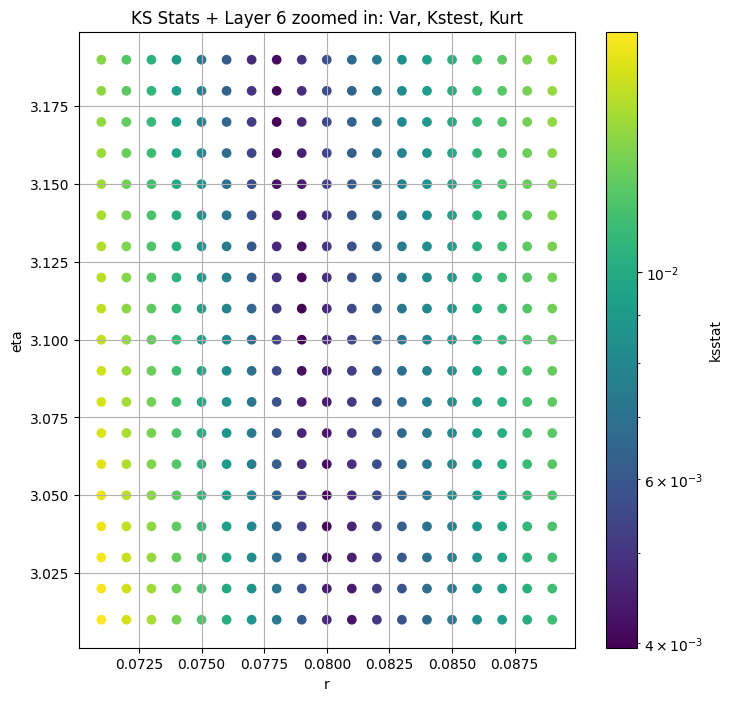

Layer 7
(0.142, 1.37), 50 of 441
(0.144, 1.45), 100 of 441
(0.147, 1.32), 150 of 441
(0.149, 1.4), 200 of 441
(0.151, 1.48), 250 of 441
(0.154, 1.35), 300 of 441
(0.156, 1.43), 350 of 441
(0.159, 1.3), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 299.24it/s]


Finding Minimum after computing 441 CDFs
7 -50 150 0.004768537522061966 27.104929 minus50


100%|██████████| 441/441 [00:01<00:00, 307.02it/s]


Finding Minimum after computing 441 CDFs
7 -40 160 0.0043415941299331795 26.66927 minus40


100%|██████████| 441/441 [00:01<00:00, 312.96it/s]


Finding Minimum after computing 441 CDFs
7 -30 170 0.004027407807158101 26.26491 minus30


100%|██████████| 441/441 [00:01<00:00, 312.88it/s]


Finding Minimum after computing 441 CDFs
7 -20 180 0.003786609244875727 25.888252 minus20


100%|██████████| 441/441 [00:01<00:00, 309.24it/s]


Finding Minimum after computing 441 CDFs
7 -10 170 0.004027407807158101 26.26491 minus10


100%|██████████| 441/441 [00:01<00:00, 304.33it/s]


Finding Minimum after computing 441 CDFs
7 0 180 0.003786609244875727 25.888252 0


100%|██████████| 441/441 [00:01<00:00, 311.08it/s]


Finding Minimum after computing 441 CDFs
7 10 190 0.003785535757677705 25.535982 plus10


100%|██████████| 441/441 [00:01<00:00, 306.99it/s]


Finding Minimum after computing 441 CDFs
7 20 210 0.003808922886979038 24.89422 plus20


100%|██████████| 441/441 [00:01<00:00, 311.48it/s]


Finding Minimum after computing 441 CDFs
7 30 220 0.003809146012837883 24.600216 plus30


100%|██████████| 441/441 [00:01<00:00, 313.17it/s]


Finding Minimum after computing 441 CDFs
7 40 230 0.003815862089422417 24.321436 plus40


100%|██████████| 441/441 [00:01<00:00, 312.71it/s]


Finding Minimum after computing 441 CDFs
7 50 240 0.003832963067972872 24.056568 plus50
Number of samples: 100000, Without approximation : 9216000.0
Iter 1 layer 7 best parameters: (0.153, 1.31, 5.731469749183669e-08, 190.0, 0.003785535757677705)


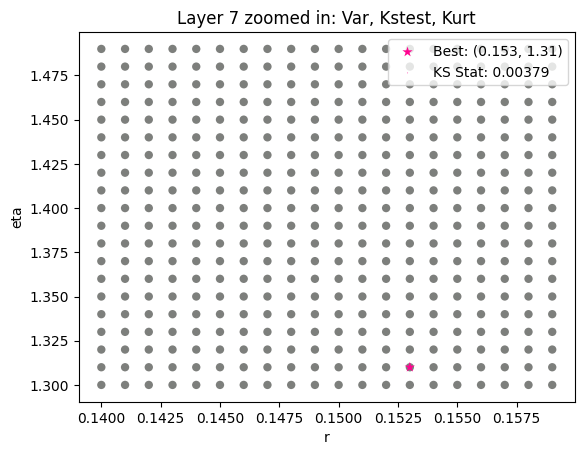

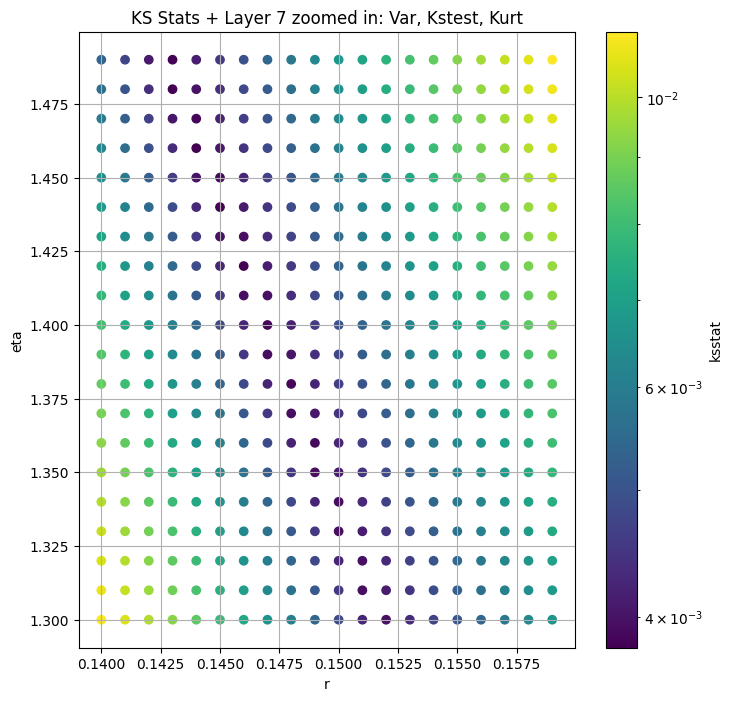

Layer 8
(0.112, 1.77), 50 of 441
(0.114, 1.85), 100 of 441
(0.117, 1.72), 150 of 441
(0.119, 1.8), 200 of 441
(0.121, 1.88), 250 of 441
(0.124, 1.75), 300 of 441
(0.126, 1.83), 350 of 441
(0.129, 1.7), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 301.14it/s]


Finding Minimum after computing 441 CDFs
8 -50 50 0.007521382940268384 13.967173 minus50


100%|██████████| 441/441 [00:01<00:00, 307.96it/s]


Finding Minimum after computing 441 CDFs
8 -40 60 0.0049323761539449285 13.371218 minus40


100%|██████████| 441/441 [00:01<00:00, 302.35it/s]


Finding Minimum after computing 441 CDFs
8 -30 70 0.003999817783010062 12.896617 minus30


100%|██████████| 441/441 [00:01<00:00, 308.16it/s]


Finding Minimum after computing 441 CDFs
8 -20 80 0.0033499999999982988 12.506496 minus20


100%|██████████| 441/441 [00:01<00:00, 304.05it/s]


Finding Minimum after computing 441 CDFs
8 -10 90 0.0033499999999960783 12.178586 minus10


100%|██████████| 441/441 [00:01<00:00, 308.20it/s]


Finding Minimum after computing 441 CDFs
8 0 90 0.0033499999999960783 12.178586 0


100%|██████████| 441/441 [00:01<00:00, 307.30it/s]


Finding Minimum after computing 441 CDFs
8 10 100 0.0033499999999956342 11.896943 plus10


100%|██████████| 441/441 [00:01<00:00, 305.38it/s]


Finding Minimum after computing 441 CDFs
8 20 120 0.0033499999999956342 11.432317 plus20


100%|██████████| 441/441 [00:01<00:00, 307.42it/s]


Finding Minimum after computing 441 CDFs
8 30 130 0.0033499999999955232 11.236934 plus30


100%|██████████| 441/441 [00:01<00:00, 305.27it/s]


Finding Minimum after computing 441 CDFs
8 40 170 0.0033499999999955232 10.613353 plus40


100%|██████████| 441/441 [00:01<00:00, 307.36it/s]


Finding Minimum after computing 441 CDFs
8 50 180 0.0033499999999955232 10.485675 plus50
Number of samples: 100000, Without approximation : 36864000.0
Iter 1 layer 8 best parameters: (0.124, 1.73, 1.579140050840482e-11, 130.0, 0.0033499999999955232)


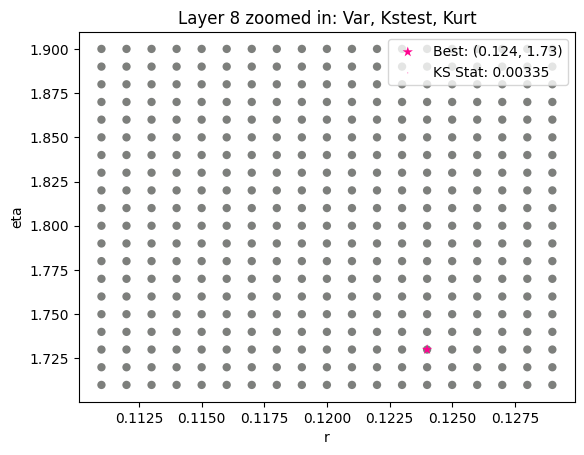

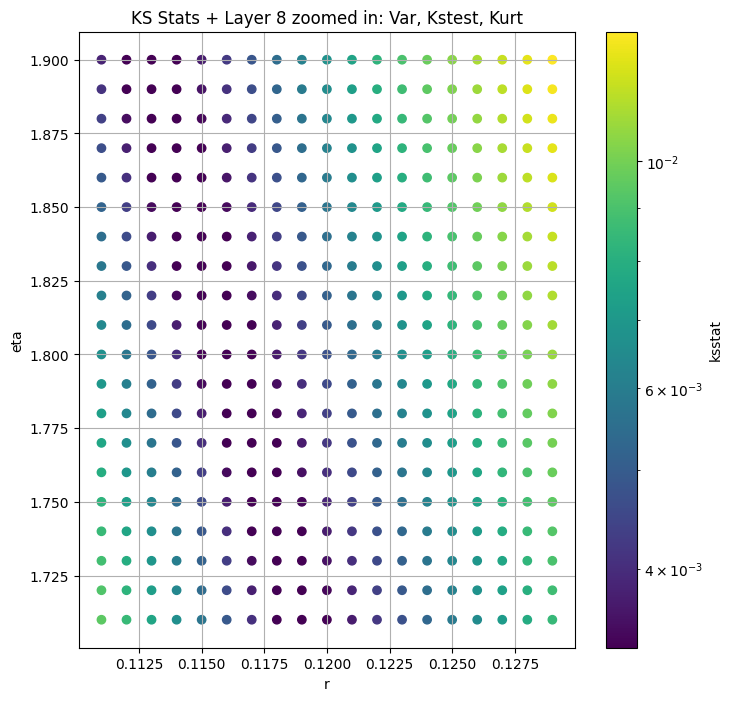

Layer 9
(0.112, 1.47), 50 of 441
(0.114, 1.55), 100 of 441
(0.117, 1.42), 150 of 441
(0.119, 1.5), 200 of 441
(0.121, 1.58), 250 of 441
(0.124, 1.45), 300 of 441
(0.126, 1.53), 350 of 441
(0.129, 1.4), 400 of 441


100%|██████████| 441/441 [00:02<00:00, 180.06it/s]


Finding Minimum after computing 441 CDFs
9 -50 100 0.00594999999998258 3.2806263 minus50


100%|██████████| 441/441 [00:02<00:00, 187.03it/s]


Finding Minimum after computing 441 CDFs
9 -40 110 0.005949999999982469 3.213779 minus40


100%|██████████| 441/441 [00:02<00:00, 185.78it/s]


Finding Minimum after computing 441 CDFs
9 -30 120 0.005949999999982469 3.1543655 minus30


100%|██████████| 441/441 [00:02<00:00, 188.13it/s]


Finding Minimum after computing 441 CDFs
9 -20 130 0.005949999999982469 3.1008346 minus20


100%|██████████| 441/441 [00:02<00:00, 182.70it/s]


Finding Minimum after computing 441 CDFs
9 -10 140 0.005949999999982469 3.0520806 minus10


100%|██████████| 441/441 [00:02<00:00, 185.83it/s]


Finding Minimum after computing 441 CDFs
9 0 150 0.005949999999982247 3.0072985 0


100%|██████████| 441/441 [00:02<00:00, 185.66it/s]


Finding Minimum after computing 441 CDFs
9 10 160 0.005949999999982358 2.965858 plus10


100%|██████████| 441/441 [00:02<00:00, 183.90it/s]


Finding Minimum after computing 441 CDFs
9 20 170 0.005949999999982247 2.9272573 plus20


100%|██████████| 441/441 [00:02<00:00, 188.50it/s]


Finding Minimum after computing 441 CDFs
9 30 180 0.005949999999982247 2.8910966 plus30


100%|██████████| 441/441 [00:02<00:00, 186.45it/s]


Finding Minimum after computing 441 CDFs
9 40 190 0.005949999999982247 2.8570762 plus40


100%|██████████| 441/441 [00:02<00:00, 185.17it/s]


Finding Minimum after computing 441 CDFs
9 50 200 0.005949999999982247 2.8249547 plus50
Number of samples: 100000, Without approximation : 147456000.0
Iter 1 layer 9 best parameters: (0.121, 1.48, 3.1452673204186243e-12, 150.0, 0.005949999999982247)


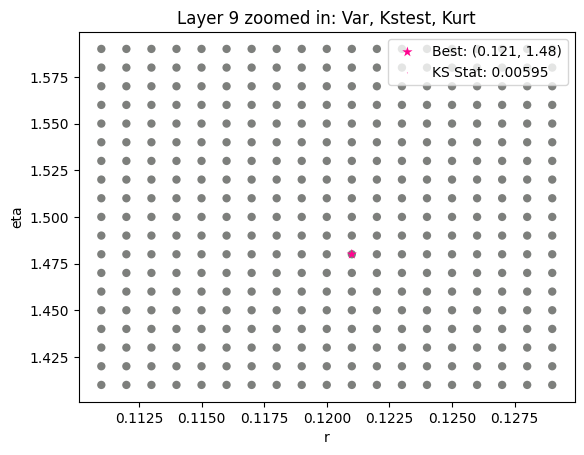

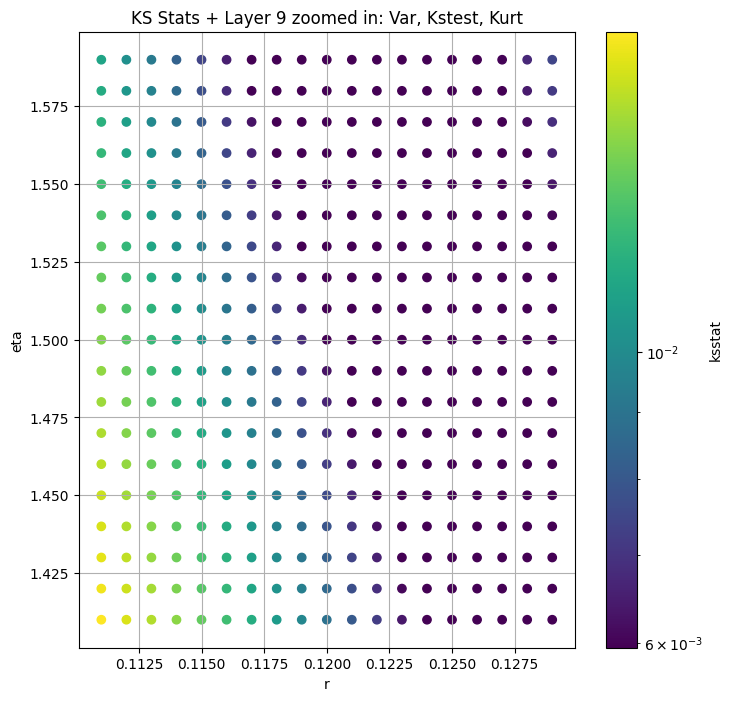

Layer 10
(3.2, -1.093), 50 of 420
(3.4, -1.085), 100 of 420
(3.7, -1.098), 150 of 420
(3.9, -1.09), 200 of 420
(4.1, -1.082), 250 of 420
(4.4, -1.095), 300 of 420
(4.6, -1.087), 350 of 420
(4.9, -1.1), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 286.46it/s]


Finding Minimum after computing 420 CDFs
10 -50 450 0.026099999999969814 0.32011962 minus50


100%|██████████| 420/420 [00:01<00:00, 294.63it/s]


Finding Minimum after computing 420 CDFs
10 -40 410 0.026349460355212018 0.32880992 minus40


100%|██████████| 420/420 [00:01<00:00, 306.30it/s]


Finding Minimum after computing 420 CDFs
10 -30 420 0.02610478031782071 0.32655862 minus30


100%|██████████| 420/420 [00:01<00:00, 306.58it/s]


Finding Minimum after computing 420 CDFs
10 -20 430 0.02609999999996998 0.32435825 minus20


100%|██████████| 420/420 [00:01<00:00, 305.66it/s]


Finding Minimum after computing 420 CDFs
10 -10 440 0.02609999999996976 0.32221308 minus10


100%|██████████| 420/420 [00:01<00:00, 302.48it/s]


Finding Minimum after computing 420 CDFs
10 0 440 0.02609999999996976 0.32221308 0


100%|██████████| 420/420 [00:01<00:00, 304.70it/s]


Finding Minimum after computing 420 CDFs
10 10 450 0.026099999999969814 0.32011962 plus10


100%|██████████| 420/420 [00:01<00:00, 307.33it/s]


Finding Minimum after computing 420 CDFs
10 20 460 0.02609999999996948 0.3180759 plus20


100%|██████████| 420/420 [00:01<00:00, 306.43it/s]


Finding Minimum after computing 420 CDFs
10 30 490 0.026099999999969592 0.31220645 plus30


100%|██████████| 420/420 [00:01<00:00, 304.96it/s]


Finding Minimum after computing 420 CDFs
10 40 500 0.02609999999996998 0.3103359 plus40


100%|██████████| 420/420 [00:01<00:00, 306.59it/s]


Finding Minimum after computing 420 CDFs
10 50 510 0.02609999999997009 0.30849677 plus50
Number of samples: 100000, Without approximation : 589824000.0
Iter 1 layer 10 best parameters: (4.2, -1.097, 1.1818800686764288, 460.0, 0.02609999999996948)


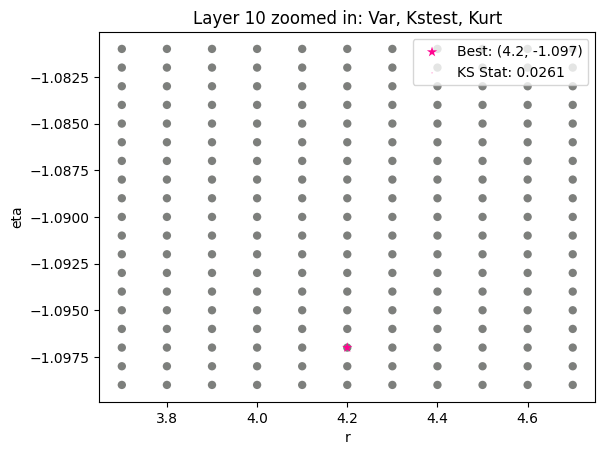

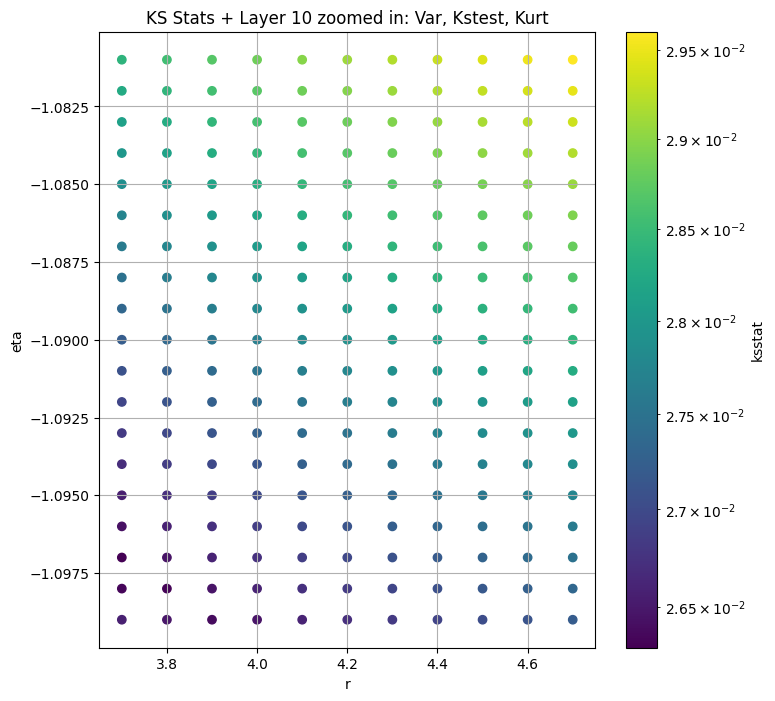

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       760.94360         9000.0             0.013681       0.05         5.90   
3       891.27313        36000.0             0.012923       0.06         4.10   
4      1768.95340       144000.0             0.007640       0.05         4.20   
5      2074.88330       576000.0             0.005897       0.07         2.80   
6      3444.52950      2304000.0             0.004094       0.08         3.10   
7      5672.12000      9216000.0             0.003812       0.15         1.40   
8      4638.63770     36864000.0             0.003350       0.12         1.80   
9      6105.37160    147456000.0             0.005950       0.12         1.50   
10     7496.85840    589824000.0             0.026100       4.00        -1.09   

       initial_scale  best_exclude_cutoff  best_augmented_var  \
layer                                                           
2       6.117604e-40                 25.0        53255.480469   
3       3.767124e-30                190.0         9853.148438   
4       3.466181e-39                330.0         2361.149170   
5       2.990083e-24                290.0          451.927185   
6       3.029738e-21                240.0           98.109856   
7       2.759916e-08                190.0           25.535982   
8       4.352079e-12                130.0           11.236934   
9       2.218216e-12                150.0            3.007298   
10      1.138467e+00                460.0            0.318076   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.013406   0.050     5.880   
3                     0.007153          0.012870   0.059     4.130   
4                     0.003578          0.007157   0.050     4.180   
5                     0.001789          0.005735   0.069     2.810   
6                     0.000895          0.003956   0.078     3.170   
7                     0.000447          0.003786   0.153     1.310   
8                     0.000224          0.003350   0.124     1.730   
9                     0.000112          0.005950   0.121     1.480   
10                    0.000056          0.026100   4.200    -1.097   

         best_scale  n_pval_0.05  
layer                             
2      6.437224e-40        10125  
3      7.202923e-31        11389  
4      3.780162e-39        36000  
5      9.940858e-25        54000  
6      4.913900e-22       121500  
7      5.731470e-08       129742  
8      1.579140e-11       162000  
9      3.145267e-12        54000  
10     1.181880e+00         2845

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(-50, 51, 10)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 1
            eta_granularity = 1
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), round_to_sigfigs(initial_eta, 1)]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([round_to_sigfigs(initial_r, 1), round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    eta_granularity = 10.**i
                    
            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']

                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                group_cdfs = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                group_cdfs_df = create_kurt_var_ksstat_df(group_cdfs)

                for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                    exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                    
                    if exclude_cutoff == 0:
                        augmented_var = np.var(group_data_map[group])
                    else:
                        augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                    group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                    ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                    
                    cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                    augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                    group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                    
                    print(group, adjust_exclude_cutoff, exclude_cutoff, min_stat, augmented_var, cutoff_label)
                    best_adjust = 0

                    if min_stat < master_df.loc[group, 'kstest_stat_best']:

                        inital_min_stat = min_stat
                        inital_best_param = initial_param
                        master_df.loc[group, 'kstest_stat_best'] = min_stat
                        initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                        master_df.loc[group, 'best_scale'] = initial_scale
                        master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                        master_df.loc[group, 'best_augmented_var'] = augmented_var
                        augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                        best_adjust = adjust_exclude_cutoff

                cutoff_label = generate_cutoff_label(best_adjust)
                ksstats = group_cdfs_df[f"ksstat_exclude_{best_adjust}"]
                
                print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
                
                cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
                master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

                best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

                group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
                group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

                group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

                group_dict = rEtaKsstats_dict[group]
                group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
                rEtaKsstats_dict[group] = group_dict

                print(f"Iter {d} {GROUP} {group} best parameters: {master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'], master_df.loc[group, 'best_scale'], master_df.loc[group, 'best_exclude_cutoff'], master_df.loc[group, f'kstest_stat_best']}")

            filtered_df = group_cdfs_df[(group_cdfs_df['r'] > master_df.loc[group, 'initial_r'] - r_granularity) & 
                            (group_cdfs_df['r'] < master_df.loc[group, 'initial_r'] + r_granularity) &
                            (group_cdfs_df['eta'] > master_df.loc[group, 'initial_eta'] - eta_granularity) &
                            (group_cdfs_df['eta'] < master_df.loc[group, 'initial_eta'] + eta_granularity)]
            
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))